<a href="https://colab.research.google.com/github/ParzivalStark/Velocity-Obstacles/blob/main/Simulation_VO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from shapely import Point, Polygon, intersection
from IPython.display import display, clear_output

In [81]:
# Function to plot a circle
def plot_circle(ax, center, radius, color='r', fill=True, alpha=0.5):
    circle = Circle(center, radius, color=color, fill=fill, alpha=alpha)
    ax.add_patch(circle)


def get_CC_angles(A_pos, A_vel, B_pos, B_vel):
  relative_position = B_pos - A_pos
  relative_velocity = B_vel - A_vel

  # Calculate the collision cone angle
  distance_A_to_B = np.linalg.norm(relative_position)
  theta = np.arctan2(relative_position[1], relative_position[0])
  beta = np.arcsin((A_radius + B_radius) / distance_A_to_B)
  #print("Theta", np.rad2deg(theta), "Beta", np.rad2deg(beta), "D", distance_A_to_B)

  return [theta, beta, distance_A_to_B]


def get_CC_bounderies(A_pos, theta, beta, distance_A_to_B):
  # Define the Collision Cone bounderies (CC_A,B)
  rear_line = A_pos + distance_A_to_B * np.array([np.cos(theta + beta),
                                          np.sin(theta + beta)])
  front_line = A_pos + distance_A_to_B * np.array([np.cos(theta - beta),
                                          np.sin(theta - beta)])

  return [rear_line, front_line]

def get_vel_ob(theta, beta, distance_A_to_B, B_vel, numPoints):

  # Discretization
  angles = np.linspace(theta - beta, theta + beta, numPoints)
  conePoints = np.array([np.cos(angles), np.sin(angles)]).T

  distances = np.linspace(0, distance_A_to_B, numPoints)
  VO_A_B = []

  for distance in distances:
    tmp = (conePoints * distance) + B_vel
    VO_A_B.append(tmp)

  VO_A_B = np.array(VO_A_B)

  return VO_A_B

def get_reachable_velocities(A_pos, A_vel, v_max, a_max, dt=1.0, num_points=100):

    # Create a range of angles that span a full circle for acceleration directions
    angles = np.linspace(0, 2 * np.pi, num_points)

    # Compute the x and y components of the acceleration vectors
    circlePoints = np.array([np.cos(angles), np.sin(angles)]).T

    accelerations = np.linspace(-a_max, a_max, numPoints)
    acc_set = []

    for acc in accelerations:
      tmp = (circlePoints) * acc
      acc_set.append(tmp)

    acc_set = np.array(acc_set)

    # Compute the set of velocities by adding accelerations to the current velocity
    vel_set = []

    for i in acc_set:
      for j in i:
        # Compute the new velocity after applying this acceleration
        v_new = A_vel + j * dt

        # Check if the new velocity would exceed the maximum velocity
        if np.linalg.norm(v_new) <= v_max:
            vel_set.append(v_new)

    vel_set = np.array(vel_set)

    return vel_set

def side_of_line(A, B, P):
  x1, y1 = A
  x2, y2 = B
  x0, y0 = P

  cross_product = (x2 - x1) * (y0 - y1) - (y2 - y1) * (x0 - x1)

  if cross_product > 0:
    return -1 # Left
  elif cross_product < 0:
    return  1 # Right
  else:
    return  0 # On the line


def inside_VO(P, A_pos, front_line, rear_line):
  front = side_of_line(A_pos, front_line, P)
  rear = side_of_line(A_pos, rear_line, P)
  return front in [0, -1] and rear in [0, 1]

def get_RAV(A_pos, B_vel, rear_line, front_line, reachable_vel_set):
  RAV = []

  #t_A =(A_pos[0] + B_vel[0], A_pos[1] + B_vel[1])
  #t_B =(rear_line[0] + B_vel[0], rear_line[1] + B_vel[1])
  #t_C =(front_line[0] + B_vel[0], front_line[1] + B_vel[1])
  #VO = Polygon((t_A, t_B, t_C))

  for vel in reachable_vel_set:
    p_vel = vel + A_pos
    if not inside_VO(p_vel, A_pos + B_vel, front_line, rear_line):
      RAV.append(vel)

  RAV = np.array(RAV)

  return RAV

def get_best_vel(goal, A_pos, RAV):
  rel_pos_goal = goal - A_pos
  theta = np.arctan2(rel_pos_goal[1], rel_pos_goal[0])
  #print(theta)
  best_vel = np.array([0, 0])
  best_error = float("inf")
  for vel in RAV:
    ang = np.arctan2(vel[1], vel[0])
    error = abs(ang - theta)
    #print(ang)
    if (error <= best_error):
      #print(vel, ang)
      if error == best_error:
        if np.linalg.norm(vel) > np.linalg.norm(best_vel):
          best_vel = vel
          best_error = error
      else:
          best_vel = vel
          best_error = error
  print("Best", best_vel)
  return best_vel

##### Plot functions ######
def plot_vel_ob(A_pos, A_vel, A_radius, B_pos, B_vel, B_radius, rear_line, front_line, VO):#, theta, d):
  fig, ax = plt.subplots()
  ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
  ax.quiver(*B_pos, *B_vel, color='r', scale_units='xy', scale=1, label="Velocity B")
  ax.quiver(*A_pos, *B_vel, color='r', scale_units='xy', scale=1)

  # Plot the Velocity Obstacle (VO_B)
  plot_circle(ax, B_pos, B_radius + A_radius, color='r', fill=False)
  ax.plot([A_pos[0] + B_vel[0], rear_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], rear_line[1] + B_vel[1]], 'cyan')
  ax.plot([A_pos[0] + B_vel[0], front_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], front_line[1] + B_vel[1]], 'cyan')
  #ax.plot([A_pos[0], d*np.cos(theta)+A_pos[0]], [A_pos[1], d*np.sin(theta)+A_pos[1]])

  #for points in VO:
    #ax.plot(points[:, 0], points[:, 1], color='cyan')

  # Plot configuration
  ax.set_xlim(-2, 8)
  ax.set_ylim(-2, 8)
  ax.set_aspect('equal')
  ax.legend()
  ax.set_title('Velocity Obstacle')
  plt.xlabel('Velocity X (m/s)')
  plt.ylabel('Velocity Y (m/s)')
  plt.grid(True)
  plt.show()

def plot_RV(A_pos, A_vel, reachable_vel_set):
  fig, ax = plt.subplots()
  plt.scatter(reachable_vel_set[:, 0] + A_pos[0], reachable_vel_set[:, 1] + A_pos[1], label="reachable Velocities")
  ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
  ax.set_xlim(-2, 8)
  ax.set_ylim(-2, 8)
  ax.set_aspect('equal')
  plt.xlabel('Velocity X (m/s)')
  plt.ylabel('Velocity Y (m/s)')
  plt.grid(True)
  plt.legend()
  plt.title('reachable Velocities with Velocity Constraints')
  plt.show()

def plot_RAV(A_pos, A_vel, RAV, rear_line, front_line):
  fig, ax = plt.subplots()
  plt.scatter(RAV[:, 0] + A_pos[0], RAV[:, 1] + A_pos[1], label="RAV")
  ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")

  ax.plot([A_pos[0] + B_vel[0], rear_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], rear_line[1] + B_vel[1]], 'cyan')
  ax.plot([A_pos[0] + B_vel[0], front_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], front_line[1] + B_vel[1]], 'cyan')

  ax.set_xlim(-2, 8)
  ax.set_ylim(-2, 8)
  ax.set_aspect('equal')
  plt.xlabel('Velocity X (m/s)')
  plt.ylabel('Velocity Y (m/s)')
  plt.grid(True)
  plt.legend()
  plt.title('reachable Velocities with Velocity Constraints')
  plt.show()

def plot_best_vel(A_pos, A_vel, A_radius, B_pos, B_vel, B_radius, best_vel, rear_line, front_line):
    # Visualization
  fig, ax = plt.subplots()
  ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
  ax.quiver(*B_pos, *B_vel, color='r', scale_units='xy', scale=1, label="Velocity B")
  #ax.quiver(*A_pos, *B_vel, color='r', scale_units='xy', scale=1)
  ax.quiver(*A_pos, *best_vel, color='g', scale_units='xy', scale=1, label="Best velocity")
  ax.plot(*A_pos, marker="x", color='k', label="Pos A")

  # Plot the Velocity Obstacle (VO_B)
  plot_circle(ax, B_pos, B_radius + A_radius, color='r', fill=False)
  ax.plot([A_pos[0] + B_vel[0], rear_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], rear_line[1] + B_vel[1]], 'cyan')
  ax.plot([A_pos[0] + B_vel[0], front_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], front_line[1] + B_vel[1]], 'cyan')
  #ax.plot(best_vel[0], best_vel[1], 'go')
  # Plot configuration
  ax.set_xlim(-2, 10)
  ax.set_ylim(-2, 10)
  ax.set_aspect('equal')
  ax.legend()
  ax.set_title('Velocity Obstacle')
  plt.xlabel('Velocity X (m/s)')
  plt.ylabel('Velocity Y (m/s)')
  plt.grid(True)

  display(fig)

  clear_output(wait = True)
  plt.pause(.5)

  #plt.show()

In [88]:
# Define the environment
A_pos = np.array([0, 0])  # Position of A
A_vel = np.array([0, 0])  # Velocity of A
A_radius = 0.5            # Radius of A

B_pos = np.array([8, 8])  # Position of B
B_vel = np.array([-1, -1])  # Velocity of B
B_radius = 1              # Radius of B

numPoints = 10            # Discretization

T_h = 10

t = 0

v_max = 3.0                   # Maximum velocity (m/s)
a_max = 2.0                   # Maximum acceleration (m/s^2)
dt = 0.5                      # Time step (1 second)

goal = np.array([6, 6])     ## position of goal

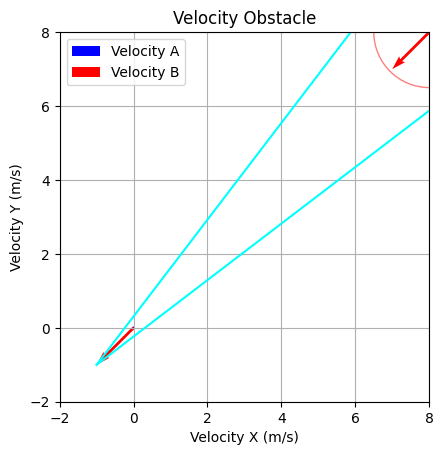

In [83]:
theta, beta, distance_A_to_B = get_CC_angles(A_pos, A_vel, B_pos, B_vel)

rear_line, front_line = get_CC_bounderies(A_pos, theta, beta, distance_A_to_B)

VO_A_B = get_vel_ob(theta, beta, distance_A_to_B, B_vel, numPoints)

plot_vel_ob(A_pos, A_vel, A_radius, B_pos, B_vel, B_radius, rear_line, front_line, VO_A_B)

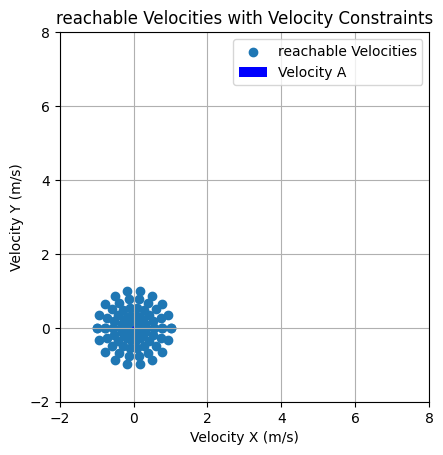

(100, 2)


In [84]:
# Get the set of feasible velocities
reachable_vel_set = get_reachable_velocities(A_pos, A_vel, v_max, a_max, dt, numPoints)

plot_RV(A_pos, A_vel, reachable_vel_set)
print(reachable_vel_set.shape)

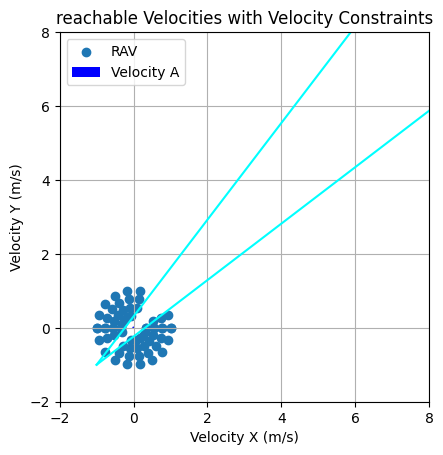

(66, 2)


In [85]:
RAV = get_RAV(A_pos, B_vel, rear_line, front_line, reachable_vel_set)

plot_RAV(A_pos, A_vel, RAV, rear_line, front_line)
print(RAV.shape)

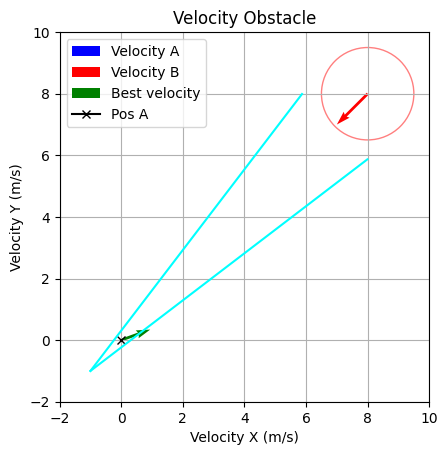

[0.93969262 0.34202014]
1.0
[0 0]


In [86]:
best_vel = get_best_vel(goal, A_pos, RAV)

plot_best_vel(A_pos, A_vel, A_radius, B_pos, B_vel, B_radius, best_vel, rear_line, front_line)

print(best_vel)
print(np.linalg.norm(best_vel))
print(A_pos)
#if best_vel in RAV:
  #print(RAV)

In [58]:
# MANUAL Update values
A_vel = best_vel

A_pos = A_pos + (dt * A_vel)

B_pos = B_pos + (dt * B_vel)

t += dt

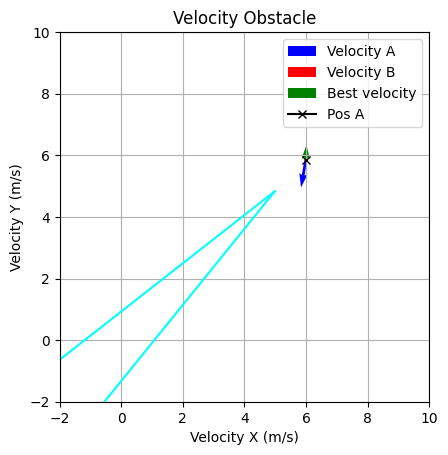

In [89]:
distance_A_to_goal = np.linalg.norm(goal - A_pos)

while distance_A_to_goal > 0.2:

  distance_A_to_goal = np.linalg.norm(goal - A_pos)

  # Calculate new velocity
  theta, beta, distance_A_to_B = get_CC_angles(A_pos, A_vel, B_pos, B_vel)

  rear_line, front_line = get_CC_bounderies(A_pos, theta, beta, distance_A_to_B)

  VO_A_B = get_vel_ob(theta, beta, distance_A_to_B, B_vel, numPoints)

  reachable_vel_set = get_reachable_velocities(A_vel, v_max, a_max, dt, numPoints)

  RAV = get_RAV(A_pos, B_vel, rear_line, front_line, reachable_vel_set)

  best_vel = get_best_vel(goal, A_pos, RAV)

  plot_best_vel(A_pos, A_vel, A_radius, B_pos, B_vel, B_radius, best_vel, rear_line, front_line)

  # Update values
  A_vel = best_vel

  A_pos = A_pos + (dt * A_vel)

  B_pos = B_pos + (dt * B_vel)

  t += dt